In [1]:
%load_ext autoreload

In [2]:
import lightning.pytorch as pl
import torch
import os
import dask.dataframe as dd
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import anndata
from matplotlib import rcParams

In [12]:
%autoreload 2
from self_supervision.estimator.cellnet import EstimatorAutoEncoder
from self_supervision.tester.classifier.test import eval_emb_knn
from self_supervision.tester.classifier.test import get_total_correct
from self_supervision.data.datamodules import get_large_ood_dataloader
from self_supervision.data.ood_adata import create_ood_dataloader
from self_supervision.paths import DATA_DIR, TRAINING_FOLDER, RESULTS_FOLDER, OOD_FOLDER

In [4]:
STORE_DIR = os.path.join(DATA_DIR, 'merlin_cxg_2023_05_15_sf-log1p')

In [5]:
# Set the global font to be Calibri, size 6
rcParams['font.family'] = 'Calibri'
rcParams['font.size'] = 6

# Figure 1
Compare performance on hold out test set on CellNet

kNN classification to include PCA, scVI, Only Pretrained, Supervised, and Self-Supervised

1) Full Transcriptome

In [6]:
# init estim class
estim = EstimatorAutoEncoder(STORE_DIR, hvg=False)

In [7]:
# init datamodule
estim.init_datamodule(batch_size=512) 

In [8]:
estim.trainer = pl.Trainer(logger=[], accelerator='gpu', devices=1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
# PCA and Random as well
model_dirs = [
    ### Supervised Models ###
    
    # TRAINING_FOLDER + '/final_models/classification/No_SSL_run0/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # TRAINING_FOLDER + '/final_models/classification/No_SSL_run1/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # TRAINING_FOLDER + '/final_models/classification/No_SSL_run2/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # TRAINING_FOLDER + '/final_models/classification/No_SSL_run3/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # TRAINING_FOLDER + '/final_models/classification/No_SSL_run4/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    
    ### Only Pretrained Models ###
    
    # Individual Gene Masking
    # TRAINING_FOLDER + '/pretext_models/masking/CN_MLP_50p/default/version_1/checkpoints/best_checkpoint_val.ckpt',
    
    # Gene Program Masking
    # TRAINING_FOLDER + '/pretext_models/masking/CN_MLP_gene_program_C8_25p/default/version_2/checkpoints/best_checkpoint_val.ckpt',

    # Gene Program to Gene Program
    # TRAINING_FOLDER + '/pretext_models/masking/CN_MLP_single_gene_program/default/version_1/checkpoints/best_checkpoint_val.ckpt',
    
    # Gene Program to Transcription Factor    
    # TRAINING_FOLDER + '/pretext_models/masking/CN_MLP_gp_to_tf/default/version_2/checkpoints/best_checkpoint_val.ckpt',
    
    # Boostrap Your Own Latent (BYOL)
    # TRAINING_FOLDER + '/pretext_models/contrastive/MLP_BYOL_Gaussian_0_001_v4/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    
    # Barlow Twins
    # TRAINING_FOLDER + '/pretext_models/contrastive/MLP_bt_Gaussian_0_001/best_checkpoint_val.ckpt',
    
    ### Self-Supervised Models ###
    
    # Individual Gene Masking
    # TRAINING_FOLDER + '/final_models/classification/SSL_CN_MLP_50prun0/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # TRAINING_FOLDER + '/final_models/classification/SSL_CN_MLP_50prun1/default/version_1/checkpoints/best_checkpoint_val.ckpt',
    # TRAINING_FOLDER + '/final_models/classification/SSL_CN_MLP_50prun2/default/version_1/checkpoints/best_checkpoint_val.ckpt',
    # TRAINING_FOLDER + '/final_models/classification/SSL_CN_MLP_50prun3/default/version_1/checkpoints/best_checkpoint_val.ckpt',
    # TRAINING_FOLDER + '/final_models/classification/SSL_CN_MLP_50prun4/default/version_1/checkpoints/best_checkpoint_val.ckpt',
    
    # Gene Program Masking
    # TRAINING_FOLDER + '/final_models/classification/SSL_CN_MLP_gene_program_C8_25prun0/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # TRAINING_FOLDER + '/final_models/classification/SSL_CN_MLP_gene_program_C8_25prun1/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # TRAINING_FOLDER + '/final_models/classification/SSL_CN_MLP_gene_program_C8_25prun2/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # TRAINING_FOLDER + '/final_models/classification/SSL_CN_MLP_gene_program_C8_25prun3/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # TRAINING_FOLDER + '/final_models/classification/SSL_CN_MLP_gene_program_C8_25prun4/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    
    # Gene Program to Gene Program
    # TRAINING_FOLDER + '/final_models/classification/SSL_CN_MLP_single_gene_programrun0/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    
    # Gene Program to Transcription Factor
    # TRAINING_FOLDER + '/final_models/classification/SSL_CN_MLP_gp_to_tfrun0/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    
    # Boostrap Your Own Latent (BYOL)
    # TRAINING_FOLDER + '/final_models/classification/SSL_MLP_BYOL_Gaussian_0_001run0/default/version_1/checkpoints/best_checkpoint_val.ckpt',
    
    # Barlow Twins
    # TRAINING_FOLDER + '/final_models/classification/SSL_contrastive_MLP_bt_Gaussian_0_01run0/default/version_0/checkpoints/best_checkpoint_val.ckpt',
]

In [ ]:
eval_emb_knn(estim, model_dirs, eval_random=False, eval_pca=False)

In [ ]:
model_dir_trick = []
for i in range(len(model_dirs)):
    print('Evaluate model: ', model_dir_trick)
    model_dir_trick = []
    model_dir_trick.append(model_dirs[i])
    eval_emb_knn(estim, model_dir_trick, eval_random=False, eval_pca=False)
    torch.cuda.empty_cache()

In [ ]:
# Reading the uploaded CSV file to understand its contents
import pandas as pd

# Load the CSV file into a DataFrame
file_path = os.path.join(RESULTS_FOLDER, 'classification', 'val_clf_report_CellNet_knn.csv')
df = pd.read_csv(file_path)

# Show the first few rows to get an overview of the data
df

# Figure 2

OOD task, where supervised learning may come to its limits

Novel, unseen dataset

**Dissection: Tail of Hippocampus (HiT) - Caudal Hippocampus - CA4-DGC**

- 56,367 cells
- 10x 3' v3
- hippocampal formation
- astrocyte (3761), central nervous system macrophage (1782), endothelial cell (174), ependymal cell (111), ~~fibroblast (86)~~, leukocyte (36), neuron (36588), oligodendrocyte (11875), oligodendrocyte precursor cell (1896), pericyte (39), vascular associated smooth muscle cell (19)

In [ ]:
test_loader_hit = create_ood_dataloader(adata_path=os.path.join(OOD_FOLDER, 'tail_of_hippocampus', 'tail_of_hippocampus.h5ad'), data_path=STORE_DIR, batch_size=32)

In [ ]:
model_dirs = [
    ### Supervised Models ###
    
    TRAINING_FOLDER + '/final_models/classification/No_SSL_run0/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    TRAINING_FOLDER + '/final_models/classification/No_SSL_run1/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    TRAINING_FOLDER + '/final_models/classification/No_SSL_run2/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    TRAINING_FOLDER + '/final_models/classification/No_SSL_run3/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    TRAINING_FOLDER + '/final_models/classification/No_SSL_run4/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    
    ### Only Pretrained Models ###
    
    # Individual Gene Masking
    TRAINING_FOLDER + '/pretext_models/masking/CN_MLP_50p/default/version_1/checkpoints/best_checkpoint_val.ckpt',
    TRAINING_FOLDER + '/pretext_models/masking/CN_MLP_50prun1/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    TRAINING_FOLDER + '/pretext_models/masking/CN_MLP_50prun2/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    TRAINING_FOLDER + '/pretext_models/masking/CN_MLP_50prun3/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    TRAINING_FOLDER + '/pretext_models/masking/CN_MLP_50prun4/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    
    ### Self-Supervised Models ###
    
    # Individual Gene Masking
    TRAINING_FOLDER + '/final_models/classification/SSL_CN_MLP_50prun0/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    TRAINING_FOLDER + '/final_models/classification/SSL_CN_MLP_50prun1/default/version_1/checkpoints/best_checkpoint_val.ckpt',
    TRAINING_FOLDER + '/final_models/classification/SSL_CN_MLP_50prun2/default/version_1/checkpoints/best_checkpoint_val.ckpt',
    TRAINING_FOLDER + '/final_models/classification/SSL_CN_MLP_50prun3/default/version_1/checkpoints/best_checkpoint_val.ckpt',
    TRAINING_FOLDER + '/final_models/classification/SSL_CN_MLP_50prun4/default/version_1/checkpoints/best_checkpoint_val.ckpt',
]

In [ ]:
# init estim class
estim = EstimatorAutoEncoder(STORE_DIR, hvg=False)

In [ ]:
# init datamodule
estim.init_datamodule(batch_size=1024) 

In [ ]:
eval_emb_knn(estim, model_dirs=model_dirs, setting='OOD_HiT', test_dataloader=test_loader_hit, eval_random=True, eval_pca=False)

In [ ]:
# Reading the uploaded CSV file to understand its contents
import pandas as pd

# Load the CSV file into a DataFrame
file_path = os.path.join(RESULTS_FOLDER, 'classification', 'val_clf_report_OOD_HiT_knn.csv')
df = pd.read_csv(file_path)

# Remove duplicates
df = df.drop_duplicates()

# Show the first few rows to get an overview of the data
df

**All non-neuronal cells**

- 888,263 cells
- 10x 3' v3
- Bergmann glial cell (8041), astrocyte (155025), central nervous system macrophage (91383), ~~choroid plexus epithelial cell (7689)~~, endothelial cell (5165), ependymal cell (5882), ~~fibroblast (9156)~~, oligodendrocyte (494966), oligodendrocyte precursor cell (105734), pericyte (3693), vascular associated smooth muscle cell (1074)

In [ ]:
ood_set = 'non_neuronal'  # non_neuronal

In [ ]:
# Load OOD data
x_file_path = os.path.join(OOD_FOLDER, ood_set, 'processed_tensor_x.hdf5')
y_file_path = os.path.join(OOD_FOLDER, ood_set, 'processed_tensor_y.hdf5')
ood_dataloader = get_large_ood_dataloader(x_file_path, y_file_path, batch_size=1024)

In [ ]:
model_dirs = [
    ### Supervised Models ###
    
    TRAINING_FOLDER + '/final_models/classification/No_SSL_run0/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    TRAINING_FOLDER + '/final_models/classification/No_SSL_run1/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    TRAINING_FOLDER + '/final_models/classification/No_SSL_run2/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    TRAINING_FOLDER + '/final_models/classification/No_SSL_run3/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    TRAINING_FOLDER + '/final_models/classification/No_SSL_run4/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    
    ### Only Pretrained Models ###
    
    # Individual Gene Masking
    TRAINING_FOLDER + '/pretext_models/masking/CN_MLP_50p/default/version_1/checkpoints/best_checkpoint_val.ckpt',
    TRAINING_FOLDER + '/pretext_models/masking/CN_MLP_50prun1/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    TRAINING_FOLDER + '/pretext_models/masking/CN_MLP_50prun2/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    TRAINING_FOLDER + '/pretext_models/masking/CN_MLP_50prun3/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    TRAINING_FOLDER + '/pretext_models/masking/CN_MLP_50prun4/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    
    ### Self-Supervised Models ###
    
    # Individual Gene Masking
    TRAINING_FOLDER + '/final_models/classification/SSL_CN_MLP_50prun0/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    TRAINING_FOLDER + '/final_models/classification/SSL_CN_MLP_50prun1/default/version_1/checkpoints/best_checkpoint_val.ckpt',
    TRAINING_FOLDER + '/final_models/classification/SSL_CN_MLP_50prun2/default/version_1/checkpoints/best_checkpoint_val.ckpt',
    TRAINING_FOLDER + '/final_models/classification/SSL_CN_MLP_50prun3/default/version_1/checkpoints/best_checkpoint_val.ckpt',
    TRAINING_FOLDER + '/final_models/classification/SSL_CN_MLP_50prun4/default/version_1/checkpoints/best_checkpoint_val.ckpt',
]

In [ ]:
# # init estim class
estim = EstimatorAutoEncoder(STORE_DIR, hvg=False)

In [ ]:
# init datamodule
estim.init_datamodule(batch_size=1024) 

In [ ]:
eval_emb_knn(estim, model_dirs=model_dirs, setting='OOD_nn', test_dataloader=ood_dataloader, eval_random=True, eval_pca=False)

In [ ]:
# Reading the uploaded CSV file to understand its contents
import pandas as pd

# Load the CSV file into a DataFrame
file_path = os.path.join(RESULTS_FOLDER, 'classification', 'val_clf_report_OOD_nn_knn.csv')
df = pd.read_csv(file_path)
df = df.drop_duplicates()

# Show the first few rows to get an overview of the data
df

### **Human: Great apes study**

- 156,285 cells
- 10x 3' v3 Smart-seq v4
- L2/3-6 intratelencephalic projecting glutamatergic cortical neuron (85276), L5 something not included (392), L6b glutamatergic cortical neuron (3415), astrocyte of the cerebral cortex (3047), caudial ganglio... not included (844), cerebral cortex endothelial cell (168), chandelier pval (728), cortocothalami... (3118), lamp5 GABAeric... (6416), microglial cell (1263), near-projecting ... (3461), oligodendrocyte (7876), oligodendrocyte precursor cell (2392), pvalb GABAergic (11778), sncg GABAergic (2025), sst GABAergic cortical interneuron (13593), vascular leptomeningeal cell (276), vip GABAergic cortical interneuron (10219)

In [9]:
test_loader_apes = create_ood_dataloader(adata_path=os.path.join(OOD_FOLDER, 'great_apes', 'great_apes.h5ad'), data_path=STORE_DIR, batch_size=32)

Loaded tensor_x and tensor_y from disk.
Created DataLoader.


In [10]:
model_dirs = [
    ### Supervised Models ###
    
    TRAINING_FOLDER + '/final_models/classification/No_SSL_run0/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    TRAINING_FOLDER + '/final_models/classification/No_SSL_run1/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    TRAINING_FOLDER + '/final_models/classification/No_SSL_run2/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    TRAINING_FOLDER + '/final_models/classification/No_SSL_run3/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    TRAINING_FOLDER + '/final_models/classification/No_SSL_run4/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    
    ### Only Pretrained Models ###
    
    # Individual Gene Masking
    TRAINING_FOLDER + '/pretext_models/masking/CN_MLP_50p/default/version_1/checkpoints/best_checkpoint_val.ckpt',
    TRAINING_FOLDER + '/pretext_models/masking/CN_MLP_50prun1/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    TRAINING_FOLDER + '/pretext_models/masking/CN_MLP_50prun2/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    TRAINING_FOLDER + '/pretext_models/masking/CN_MLP_50prun3/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    TRAINING_FOLDER + '/pretext_models/masking/CN_MLP_50prun4/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    
    ### Self-Supervised Models ###
    
    # Individual Gene Masking
    TRAINING_FOLDER + '/final_models/classification/SSL_CN_MLP_50prun0/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    TRAINING_FOLDER + '/final_models/classification/SSL_CN_MLP_50prun1/default/version_1/checkpoints/best_checkpoint_val.ckpt',
    TRAINING_FOLDER + '/final_models/classification/SSL_CN_MLP_50prun2/default/version_1/checkpoints/best_checkpoint_val.ckpt',
    TRAINING_FOLDER + '/final_models/classification/SSL_CN_MLP_50prun3/default/version_1/checkpoints/best_checkpoint_val.ckpt',
    TRAINING_FOLDER + '/final_models/classification/SSL_CN_MLP_50prun4/default/version_1/checkpoints/best_checkpoint_val.ckpt',
]

In [11]:
# init estim class
estim = EstimatorAutoEncoder(STORE_DIR, hvg=False)

In [12]:
# init datamodule
estim.init_datamodule(batch_size=1024) 

In [ ]:
eval_emb_knn(estim, model_dirs=model_dirs, setting='OOD_Great_Apes', test_dataloader=test_loader_apes, eval_random=True, eval_pca=False)

In [ ]:
# Reading the uploaded CSV file to understand its contents
import pandas as pd

# Load the CSV file into a DataFrame
file_path = os.path.join(RESULTS_FOLDER, 'classification', 'val_clf_report_OOD_Great_Apes_knn.csv')
df = pd.read_csv(file_path)

# Remove duplicates
df = df.drop_duplicates()

# Show the first few rows to get an overview of the data
df

# Figure 3

Does pretraining on a large, auxiliary dataset improve performance on a specific, known dataset to be classified?

## 1. HLCA

In [23]:
# TO DO: DOUBLE CHECK WITH NEW RUNS FOR HLCA

model_dirs = [
    # Individual Gene Masking
    TRAINING_FOLDER + '/pretext_models/masking/CN_MLP_50p/default/version_1/checkpoints/best_checkpoint_val.ckpt',
    TRAINING_FOLDER + '/pretext_models/masking/CN_MLP_50prun1/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    TRAINING_FOLDER + '/pretext_models/masking/CN_MLP_50prun2/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    TRAINING_FOLDER + '/pretext_models/masking/CN_MLP_50prun3/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    TRAINING_FOLDER + '/pretext_models/masking/CN_MLP_50prun4/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    
    # Gene Program Masking
    TRAINING_FOLDER + '/pretext_models/masking/CN_MLP_gene_program_C8_25p/default/version_2/checkpoints/best_checkpoint_val.ckpt',
    TRAINING_FOLDER + '/pretext_models/masking/CN_MLP_gene_program_C8_25p/default/version_0/checkpoints/best_checkpoint_val.ckpt', # To Do
    TRAINING_FOLDER + '/pretext_models/masking/CN_MLP_gene_program_C8_25p/default/version_0/checkpoints/best_checkpoint_val.ckpt', # To Do
    TRAINING_FOLDER + '/pretext_models/masking/CN_MLP_gene_program_C8_25p/default/version_0/checkpoints/best_checkpoint_val.ckpt', # To Do
    TRAINING_FOLDER + '/pretext_models/masking/CN_MLP_gene_program_C8_25p/default/version_0/checkpoints/best_checkpoint_val.ckpt', # To Do
    
    
    ### Supervised Models ###
    
    TRAINING_FOLDER + '/final_models/classification/No_SSL_new_run0_HLCA/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    TRAINING_FOLDER + '/final_models/classification/No_SSL_new_run1_HLCA/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    TRAINING_FOLDER + '/final_models/classification/No_SSL_new_run2_HLCA/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    TRAINING_FOLDER + '/final_models/classification/No_SSL_new_run3_HLCA/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    TRAINING_FOLDER + '/final_models/classification/No_SSL_new_run4_HLCA/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    
    ### Self-Supervised Models ###
    
    # Individual Gene Masking
    TRAINING_FOLDER + '/final_models/classification/SSL_CN_MLP_50pnew_run0_HLCA/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    TRAINING_FOLDER + '/final_models/classification/SSL_CN_MLP_50prun1_HLCA/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    TRAINING_FOLDER + '/final_models/classification/SSL_CN_MLP_50prun2_HLCA/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    TRAINING_FOLDER + '/final_models/classification/SSL_CN_MLP_50prun3_HLCA/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    TRAINING_FOLDER + '/final_models/classification/SSL_CN_MLP_50prun4_HLCA/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    
    
    # Gene Program Masking
    TRAINING_FOLDER + '//final_models/classification/SSL_CN_MLP_gene_program_C8_25prun0_HLCA/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    TRAINING_FOLDER + '//final_models/classification/SSL_CN_MLP_gene_program_C8_25prun1_HLCA/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    TRAINING_FOLDER + '//final_models/classification/SSL_CN_MLP_gene_program_C8_25prun2_HLCA/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    TRAINING_FOLDER + '//final_models/classification/SSL_CN_MLP_gene_program_C8_25prun3_HLCA/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    TRAINING_FOLDER + '//final_models/classification/SSL_CN_MLP_gene_program_C8_25prun4_HLCA/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    
    # Gene Program to Gene Program
    
    # Gene Program to Transcription Factor
    
    # Boostrap Your Own Latent (BYOL)
    # TRAINING_FOLDER + '/final_models/classification/SSL_MLP_BYOL_Gaussian_0_001run0_HLCA/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    
    # Barlow Twins
    # TRAINING_FOLDER + '/final_models/classification/SSL_contrastive_MLP_bt_Gaussian_0_01run0_HLCA/default/version_0/checkpoints/best_checkpoint_val.ckpt',
]

In [ ]:
eval_emb_knn(estim, model_dirs, setting='hlca', eval_random=True, eval_pca=False)

In [ ]:
# Reading the uploaded CSV file to understand its contents
import pandas as pd

# Load the CSV file into a DataFrame
file_path = os.path.join(RESULTS_FOLDER, 'classification', 'val_clf_report_hlca_knn.csv')
df = pd.read_csv(file_path)

# Remove duplicates
df = df.drop_duplicates()

# Show the first few rows to get an overview of the data
df

Histogram

In [8]:
%autoreload 2
from self_supervision.tester.classifier.test import eval_emb_knn_per_class

In [9]:
supervised_model = TRAINING_FOLDER + '/final_models/classification/No_SSL_new_run1_HLCA/default/version_0/checkpoints/best_checkpoint_val.ckpt'
ssl_model = TRAINING_FOLDER + '/final_models/classification/SSL_CN_MLP_50prun4_HLCA/default/version_0/checkpoints/best_checkpoint_val.ckpt'

In [ ]:
df_supervised = eval_emb_knn_per_class(estim, [supervised_model], setting='hlca')
df_ssl = eval_emb_knn_per_class(estim, [ssl_model], setting='hlca')

In [13]:
# Ensuring that the 'Cell Count' columns in both dataframes are identical
assert all(df_ssl['Cell Count'] == df_supervised['Cell Count'])

# Merging the dataframes with 'Cell Type' as the key and keeping the 'Cell Count' column common
merged_df = pd.merge(df_ssl, df_supervised[['Cell Type', 'Supervised F1']], on='Cell Type')

# Renaming columns for clarity
merged_df = merged_df.rename(columns={'Self-Supervised F1': 'F1_Self-Supervised', 'Supervised F1': 'F1_Supervised'})

# The merged dataframe now has columns: 'Cell Type', 'Cell Count', 'F1_Self-Supervised', 'F1_Supervised'
merged_df.to_csv(os.path.join(RESULTS_FOLDER, 'classification',  'val_clf_per_class_report_hlca_merged_knn.csv'))

merged_df

F1_Self-Supervised  Cell Count  \
0             0.992313        6172   
1             0.918387        2046   
2             0.960894        9870   
3             0.963771       13203   
4             0.969980         737   
5             0.971144       12084   
6             0.974449        1144   
7             0.902367         652   
8             0.983123        3070   
9             0.950142        1778   
10            0.995993        8223   
11            0.919730        5178   
12            0.878103        3644   
13            0.936639         187   
14            0.982063         222   
15            0.925993        6706   
16            0.981268         689   
17            0.844614         517   
18            0.950646         852   
19            0.987144        1096   
20            0.982456          85   
21            0.905558        5365   
22            0.977742        2442   
23            0.914355        1290   
24            0.982787        3123   
25            0.994681         562   
26            0.931507         622   
27            0.933657       14469   
28            0.351544         506   
29            0.952514         341   
30            0.971590        2315   
31            0.959732         441   
32            0.984414        5197   
33            0.978091        2689   

                                          Cell Type  F1_Supervised  
0                                            B cell       0.993351  
1              CD1c-positive myeloid dendritic cell       0.910165  
2                   CD4-positive, alpha-beta T cell       0.956418  
3                   CD8-positive, alpha-beta T cell       0.961713  
4                                            T cell       0.981132  
5                               alveolar macrophage       0.969715  
6                   alveolar type 1 fibroblast cell       0.966964  
7                   alveolar type 2 fibroblast cell       0.900073  
8                       bronchus fibroblast of lung       0.978417  
9                        capillary endothelial cell       0.951412  
10  ciliated columnar cell of tracheobronchial tree       0.994606  
11                               classical monocyte       0.924746  
12                                        club cell       0.868869  
13                      conventional dendritic cell       0.960422  
14                                   dendritic cell       0.975717  
15                              elicited macrophage       0.918767  
16             endothelial cell of lymphatic vessel       0.987672  
17                                  lung macrophage       0.791266  
18                                    lung pericyte       0.960947  
19                                        mast cell       0.984475  
20                                 mesothelial cell       0.982659  
21                         nasal mucosa goblet cell       0.912430  
22                              natural killer cell       0.973549  
23                           non-classical monocyte       0.922400  
24                                      plasma cell       0.982382  
25                      plasmacytoid dendritic cell       0.995563  
26                pulmonary artery endothelial cell       0.950233  
27                           respiratory basal cell       0.935864  
28                         respiratory hillock cell       0.348512  
29                               smooth muscle cell       0.961810  
30              tracheobronchial smooth muscle cell       0.974968  
31                                type I pneumocyte       0.963048  
32                               type II pneumocyte       0.979129  
33                            vein endothelial cell       0.978660

Confusion Matrix

In [13]:
model_dirs = [
    TRAINING_FOLDER + '/final_models/classification/No_SSL_new_run1_HLCA/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    TRAINING_FOLDER + '/final_models/classification/SSL_CN_MLP_50prun4_HLCA/default/version_0/checkpoints/best_checkpoint_val.ckpt'
]

In [ ]:
correct_counts = get_total_correct(estim=estim, model_dirs=model_dirs, setting='hlca')

In [11]:
correct_counts

## 2. PBMC

In [40]:
model_dirs = [
    # Individual Gene Masking
    # TRAINING_FOLDER + '/pretext_models/masking/CN_MLP_50p/default/version_1/checkpoints/best_checkpoint_val.ckpt',
    # TRAINING_FOLDER + '/pretext_models/masking/CN_MLP_50prun1/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # TRAINING_FOLDER + '/pretext_models/masking/CN_MLP_50prun2/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # TRAINING_FOLDER + '/pretext_models/masking/CN_MLP_50prun3/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # TRAINING_FOLDER + '/pretext_models/masking/CN_MLP_50prun4/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    
    # Gene Program Masking
    # TRAINING_FOLDER + '/pretext_models/masking/CN_MLP_gene_program_C8_25p/default/version_2/checkpoints/best_checkpoint_val.ckpt',
    # TRAINING_FOLDER + '/pretext_models/masking/CN_MLP_gene_program_C8_25p/default/version_0/checkpoints/best_checkpoint_val.ckpt', # To Do
    # TRAINING_FOLDER + '/pretext_models/masking/CN_MLP_gene_program_C8_25p/default/version_0/checkpoints/best_checkpoint_val.ckpt', # To Do
    # TRAINING_FOLDER + '/pretext_models/masking/CN_MLP_gene_program_C8_25p/default/version_0/checkpoints/best_checkpoint_val.ckpt', # To Do
    # TRAINING_FOLDER + '/pretext_models/masking/CN_MLP_gene_program_C8_25p/default/version_0/checkpoints/best_checkpoint_val.ckpt', # To Do
    
    ### Supervised Models ###
    
    # TRAINING_FOLDER + '/final_models/classification/No_SSL_new_run0_PBMC/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # TRAINING_FOLDER + '/final_models/classification/No_SSL_new_run1_PBMC/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # TRAINING_FOLDER + '/final_models/classification/No_SSL_new_run2_PBMC/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # TRAINING_FOLDER + '/final_models/classification/No_SSL_new_run3_PBMC/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # TRAINING_FOLDER + '/final_models/classification/No_SSL_new_run4_PBMC/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # TRAINING_FOLDER + '/final_models/classification/No_SSL_new_run5_PBMC/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # TRAINING_FOLDER + '/final_models/classification/No_SSL_new_run6_PBMC/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    
    ### Self-Supervised Models ###
    
    # Individual Gene Masking
    # TRAINING_FOLDER + '/final_models/classification/SSL_CN_MLP_50pnew_run0_PBMC/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # TRAINING_FOLDER + '/final_models/classification/SSL_CN_MLP_50pnew_run1_PBMC/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # TRAINING_FOLDER + '/final_models/classification/SSL_CN_MLP_50pnew_run2_PBMC/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # TRAINING_FOLDER + '/final_models/classification/SSL_CN_MLP_50pnew_run3_PBMC/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # TRAINING_FOLDER + '/final_models/classification/SSL_CN_MLP_50pnew_run4_PBMC/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    
    # Gene Program Masking
    # TRAINING_FOLDER + '/final_models/classification/SSL_CN_MLP_gene_program_C8_25pnew_run0_PBMC/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # TRAINING_FOLDER + '/final_models/classification/SSL_CN_MLP_gene_program_C8_25pnew_run1_PBMC/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # TRAINING_FOLDER + '/final_models/classification/SSL_CN_MLP_gene_program_C8_25pnew_run2_PBMC/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # TRAINING_FOLDER + '/final_models/classification/SSL_CN_MLP_gene_program_C8_25pnew_run3_PBMC/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # TRAINING_FOLDER + '/final_models/classification/SSL_CN_MLP_gene_program_C8_25pnew_run4_PBMC/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    
]

In [ ]:
eval_emb_knn(estim, model_dirs, setting='pbmc', eval_random=True, eval_pca=False)

In [ ]:
# Reading the uploaded CSV file to understand its contents
import pandas as pd

# Load the CSV file into a DataFrame
file_path = os.path.join(RESULTS_FOLDER, 'classification', 'val_clf_report_pbmc_knn.csv')
df = pd.read_csv(file_path)

# Show the first few rows to get an overview of the data
df

Histogram

In [19]:
%autoreload 2
from self_supervision.tester.classifier.test import eval_emb_knn_per_class

In [20]:
supervised_model = TRAINING_FOLDER + '/final_models/classification/No_SSL_run2_PBMC/default/version_0/checkpoints/best_checkpoint_val.ckpt'
ssl_model = TRAINING_FOLDER + '/final_models/classification/SSL_CN_MLP_50pnew_run2_PBMC/default/version_0/checkpoints/best_checkpoint_val.ckpt'

In [ ]:
df_supervised = eval_emb_knn_per_class(estim, [supervised_model], setting='pbmc')
df_ssl = eval_emb_knn_per_class(estim, [ssl_model], setting='pbmc')

In [23]:
import pandas as pd

# Ensuring that the 'Cell Count' columns in both dataframes are identical
assert all(df_ssl['Cell Count'] == df_supervised['Cell Count'])

# Merging the dataframes with 'Cell Type' as the key and keeping the 'Cell Count' column common
merged_df = pd.merge(df_ssl, df_supervised[['Cell Type', 'Supervised F1']], on='Cell Type')

# Renaming columns for clarity
merged_df = merged_df.rename(columns={'Self-Supervised F1': 'F1_Self-Supervised', 'Supervised F1': 'F1_Supervised'})

# The merged dataframe now has columns: 'Cell Type', 'Cell Count', 'F1_Self-Supervised', 'F1_Supervised'
merged_df.to_csv(os.path.join(RESULTS_FOLDER, 'classification',  'val_clf_per_class_report_pbmc_merged_knn.csv'))
merged_df

F1_Self-Supervised  Cell Count  \
0             0.903427         154   
1             0.798301         555   
2             0.828407        5067   
3             0.507375         567   
4             0.787442        7122   
5             0.514677        2156   
6             0.734072         323   
7             0.974092        8950   
8             0.733333         326   
9             0.750000           5   
10            0.203774         393   
11            0.573232        1463   
12            0.400000           4   
13            0.641414        1143   
14            0.857143           3   
15            0.776471          41   
16            0.008772         138   
17            0.719178         772   
18            0.971610        4075   
19            0.909490        9923   
20            0.878542        2835   
21            0.910664        8576   
22            0.888481        1408   
23            0.971698         109   
24            0.666667           4   
25            0.958425         236   
26            1.000000         292   
27            0.854188         976   

                                            Cell Type  F1_Supervised  
0                                              B cell       0.779661  
1   CD16-negative, CD56-bright natural killer cell...       0.829569  
2                          CD4-positive helper T cell       0.818499  
3           CD4-positive, alpha-beta cytotoxic T cell       0.465072  
4           CD8-positive, alpha-beta cytotoxic T cell       0.765005  
5      central memory CD8-positive, alpha-beta T cell       0.499858  
6                        class switched memory B cell       0.696532  
7                                  classical monocyte       0.970662  
8                         conventional dendritic cell       0.732348  
9                                      dendritic cell       0.727273  
10    effector memory CD8-positive, alpha-beta T cell       0.064795  
11  effector memory CD8-positive, alpha-beta T cel...       0.514150  
12                                        erythrocyte       0.000000  
13                                 gamma-delta T cell       0.588351  
14                                        granulocyte       0.250000  
15                               innate lymphoid cell       0.808989  
16                                   mature NK T cell       0.021505  
17                           mucosal invariant T cell       0.697772  
18                                       naive B cell       0.954913  
19  naive thymus-derived CD4-positive, alpha-beta ...       0.903223  
20  naive thymus-derived CD8-positive, alpha-beta ...       0.874228  
21                                natural killer cell       0.890114  
22                             non-classical monocyte       0.883117  
23                                        plasma cell       0.893401  
24                                        plasmablast       0.666667  
25                        plasmacytoid dendritic cell       0.974138  
26                                           platelet       0.998285  
27                                  regulatory T cell       0.830964

Confusion Matrix

In [15]:
model_dirs = [
    TRAINING_FOLDER + '/final_models/classification/No_SSL_run2_PBMC/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    TRAINING_FOLDER + '/final_models/classification/SSL_CN_MLP_50pnew_run2_PBMC/default/version_0/checkpoints/best_checkpoint_val.ckpt'
]

In [ ]:
correct_counts = get_total_correct(estim=estim, model_dirs=model_dirs, setting='pbmc')

## 3. Tabula Sapiens

In [36]:
model_dirs = [
    # Individual Gene Masking
    # TRAINING_FOLDER + '/pretext_models/masking/CN_MLP_50p/default/version_1/checkpoints/best_checkpoint_val.ckpt',
    # TRAINING_FOLDER + '/pretext_models/masking/CN_MLP_50prun1/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # TRAINING_FOLDER + '/pretext_models/masking/CN_MLP_50prun2/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # TRAINING_FOLDER + '/pretext_models/masking/CN_MLP_50prun3/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # TRAINING_FOLDER + '/pretext_models/masking/CN_MLP_50prun4/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    
    # Gene Program Masking
    # TRAINING_FOLDER + '/pretext_models/masking/CN_MLP_gene_program_C8_25p/default/version_2/checkpoints/best_checkpoint_val.ckpt',
    # TRAINING_FOLDER + '/pretext_models/masking/CN_MLP_gene_program_C8_25p/default/version_0/checkpoints/best_checkpoint_val.ckpt', # To Do
    # TRAINING_FOLDER + '/pretext_models/masking/CN_MLP_gene_program_C8_25p/default/version_0/checkpoints/best_checkpoint_val.ckpt', # To Do
    # TRAINING_FOLDER + '/pretext_models/masking/CN_MLP_gene_program_C8_25p/default/version_0/checkpoints/best_checkpoint_val.ckpt', # To Do
    # TRAINING_FOLDER + '/pretext_models/masking/CN_MLP_gene_program_C8_25p/default/version_0/checkpoints/best_checkpoint_val.ckpt', # To Do
    
    ### Supervised Models ###
    
    # TRAINING_FOLDER + '/final_models/classification/No_SSL_new_run0_Tabula_Sapiens/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # TRAINING_FOLDER + '/final_models/classification/No_SSL_new_run1_Tabula_Sapiens/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # TRAINING_FOLDER + '/final_models/classification/No_SSL_new_run2_Tabula_Sapiens/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # TRAINING_FOLDER + '/final_models/classification/No_SSL_new_run3_Tabula_Sapiens/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # TRAINING_FOLDER + '/final_models/classification/No_SSL_new_run4_Tabula_Sapiens/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    
    ### Self-Supervised Models ###
    
    # Individual Gene Masking
    # TRAINING_FOLDER + '/final_models/classification/SSL_CN_MLP_50pnew_run0_Tabula_Sapiens/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # TRAINING_FOLDER + '/final_models/classification/SSL_CN_MLP_50pnew_run1_Tabula_Sapiens/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # TRAINING_FOLDER + '/final_models/classification/SSL_CN_MLP_50pnew_run2_Tabula_Sapiens/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # TRAINING_FOLDER + '/final_models/classification/SSL_CN_MLP_50pnew_run3_Tabula_Sapiens/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # TRAINING_FOLDER + '/final_models/classification/SSL_CN_MLP_50pnew_run4_Tabula_Sapiens/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    
    # Gene Program Masking
    # TRAINING_FOLDER + '/final_models/classification/SSL_CN_MLP_gene_program_C8_25pnew_run0_Tabula_Sapiens/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # TRAINING_FOLDER + '/final_models/classification/SSL_CN_MLP_gene_program_C8_25pnew_run1_Tabula_Sapiens/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # TRAINING_FOLDER + '/final_models/classification/SSL_CN_MLP_gene_program_C8_25pnew_run2_Tabula_Sapiens/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # TRAINING_FOLDER + '/final_models/classification/SSL_CN_MLP_gene_program_C8_25pnew_run3_Tabula_Sapiens/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # TRAINING_FOLDER + '/final_models/classification/SSL_CN_MLP_gene_program_C8_25pnew_run4_Tabula_Sapiens/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    
    # Gene Program to Gene Program
    
    # Gene Program to Transcription Factor
    
    # Boostrap Your Own Latent (BYOL)
    
    # Barlow Twins
]

In [ ]:
eval_emb_knn(estim, model_dirs, setting='tabula_sapiens', eval_random=True, eval_pca=False)

In [28]:
# Reading the uploaded CSV file to understand its contents
import pandas as pd

# Load the CSV file into a DataFrame
file_path = os.path.join(RESULTS_FOLDER, 'classification', 'val_clf_report_tabula_sapiens_knn.csv')
df = pd.read_csv(file_path)

# Remove duplicates
df = df.drop_duplicates()

df = df[df['Unnamed: 0'].str.contains('new_run')]

# Show the first few rows to get an overview of the data
df

Unnamed: 0  precision: accuracy  \
0        No_SSL_new_run0_Tabula_Sapiens_No SSL             0.450247   
25       No_SSL_new_run1_Tabula_Sapiens_No SSL             0.464649   
30       No_SSL_new_run2_Tabula_Sapiens_No SSL             0.449135   
35       No_SSL_new_run3_Tabula_Sapiens_No SSL             0.461514   
40       No_SSL_new_run4_Tabula_Sapiens_No SSL             0.465972   
120  SSL_CN_MLP_50pnew_run0_Tabula_Sapiens_SSL             0.495526   
145  SSL_CN_MLP_50pnew_run1_Tabula_Sapiens_SSL             0.496843   
146  SSL_CN_MLP_50pnew_run2_Tabula_Sapiens_SSL             0.487900   
147  SSL_CN_MLP_50pnew_run3_Tabula_Sapiens_SSL             0.482372   
148  SSL_CN_MLP_50pnew_run4_Tabula_Sapiens_SSL             0.488496   

     precision: macro avg  precision: weighted avg  recall: accuracy  \
0                0.313316                 0.436672          0.450247   
25               0.318175                 0.434159          0.464649   
30               0.314254                 0.439427          0.449135   
35               0.318479                 0.445367          0.461514   
40               0.329670                 0.447619          0.465972   
120              0.349458                 0.462666          0.495526   
145              0.356871                 0.468081          0.496843   
146              0.369944                 0.468194          0.487900   
147              0.359573                 0.468484          0.482372   
148              0.355660                 0.525570          0.488496   

     recall: macro avg  recall: weighted avg  f1-score: accuracy  \
0             0.286250              0.450247            0.450247   
25            0.304493              0.464649            0.464649   
30            0.280712              0.449135            0.449135   
35            0.287370              0.461514            0.461514   
40            0.306503              0.465972            0.465972   
120           0.337286              0.495526            0.495526   
145           0.337709              0.496843            0.496843   
146           0.330576              0.487900            0.487900   
147           0.328378              0.482372            0.482372   
148           0.343176              0.488496            0.488496   

     f1-score: macro avg  f1-score: weighted avg  support: accuracy  \
0               0.266878                0.403000           0.450247   
25              0.284214                0.415446           0.464649   
30              0.253358                0.401351           0.449135   
35              0.269275                0.414177           0.461514   
40              0.287162                0.419952           0.465972   
120             0.315414                0.448363           0.495526   
145             0.309239                0.445264           0.496843   
146             0.308874                0.437852           0.487900   
147             0.304901                0.434388           0.482372   
148             0.304261                0.437204           0.488496   

     support: macro avg  support: weighted avg  
0              189756.0               189756.0  
25             189756.0               189756.0  
30             189756.0               189756.0  
35             189756.0               189756.0  
40             189756.0               189756.0  
120            189756.0               189756.0  
145            189756.0               189756.0  
146            189756.0               189756.0  
147            189756.0               189756.0  
148            189756.0               189756.0

Histogram

In [49]:
%autoreload 2
from self_supervision.tester.classifier.test import eval_emb_knn_per_class

In [50]:
supervised_model = TRAINING_FOLDER + '/final_models/classification/No_SSL_new_run4_Tabula_Sapiens/default/version_0/checkpoints/best_checkpoint_val.ckpt'
ssl_model = TRAINING_FOLDER + '/final_models/classification/SSL_CN_MLP_50pnew_run0_Tabula_Sapiens/default/version_0/checkpoints/best_checkpoint_val.ckpt'


In [ ]:
df_supervised = eval_emb_knn_per_class(estim, [supervised_model], setting='tabula_sapiens')
df_ssl = eval_emb_knn_per_class(estim, [ssl_model], setting='tabula_sapiens')

In [83]:
# Ensuring that the 'Cell Count' columns in both dataframes are identical
assert all(df_ssl['Cell Count'] == df_supervised['Cell Count'])

# Merging the dataframes with 'Cell Type' as the key and keeping the 'Cell Count' column common
merged_df = pd.merge(df_ssl, df_supervised[['Cell Type', 'Supervised F1']], on='Cell Type')

# Renaming columns for clarity
merged_df = merged_df.rename(columns={'Self-Supervised F1': 'F1_Self-Supervised', 'Supervised F1': 'F1_Supervised'})

# The merged dataframe now has columns: 'Cell Type', 'Cell Count', 'F1_Self-Supervised', 'F1_Supervised'
merged_df.to_csv(os.path.join(RESULTS_FOLDER, 'classification',  'val_clf_per_class_report_tabula_sapiens_merged_knn.csv'))

Confusion Matrix

In [17]:
model_dirs = [
    TRAINING_FOLDER + '/final_models/classification/No_SSL_new_run4_Tabula_Sapiens/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    TRAINING_FOLDER + '/final_models/classification/SSL_CN_MLP_50pnew_run0_Tabula_Sapiens/default/version_0/checkpoints/best_checkpoint_val.ckpt'
]

In [ ]:
correct_counts = get_total_correct(estim=estim, model_dirs=model_dirs, setting='tabula_sapiens')

# Geneformer Baseline

In [18]:
reference_emb = os.path.join(STORE_DIR, 'geneformer', 'val', 'embs.npy')
reference_labels = os.path.join(STORE_DIR, 'geneformer', 'val', 'cell_type.npy')
test_emb = os.path.join(STORE_DIR, 'geneformer', 'test', 'embs.npy')
test_labels = os.path.join(STORE_DIR, 'geneformer', 'test', 'cell_type.npy')
REFERENCE_PATH = STORE_DIR

In [19]:
reference_labels_np = np.load(reference_labels)
reference_labels_np.shape

(3500032,)

In [20]:
reference_emb_np = np.load(reference_emb)
reference_emb_np.shape

(3500032, 512)

In [21]:
test_labels_np = np.load(test_labels)
test_labels_np.shape

(3448832,)

In [22]:
test_emb_np = np.load(test_emb)
test_emb_np.shape

(3448832, 512)

In [23]:
%autoreload 2
from self_supervision.tester.classifier.test import eval_emb_knn

In [24]:
eval_emb_knn(estim, model_dirs = [], eval_random=False, eval_pca=False, eval_file=[reference_emb, reference_labels, test_emb, test_labels])

Loaded train labels:  (15240192,) val labels:  (3500032,) test labels:  (3448832,)
Done.
Evaluating from file
Saved  GeneFormer  to  /lustre/groups/ml01/workspace/till.richter/ssl_results/classification/val_clf_report_CellNet_knn.csv


# PCA Baseline

In [153]:
reference_labels = dd.read_parquet(os.path.join(STORE_DIR, 'val'), columns=['cell_type']).compute().cell_type.tolist()
len(reference_labels)

3500032

In [154]:
reference_emb = os.path.join(STORE_DIR, 'pca', 'x_pca_val_64.npy')
test_emb = os.path.join(STORE_DIR, 'pca', 'x_pca_test_64.npy')
REFERENCE_PATH = STORE_DIR

In [155]:
reference_labels_np = np.array(dd.read_parquet(os.path.join(STORE_DIR, 'val'), columns=['cell_type']).compute().cell_type.tolist())
reference_labels_np.shape

(3500032,)

In [156]:
reference_emb_np = np.load(reference_emb)
reference_emb_np.shape

(3500032, 64)

In [157]:
test_labels_np = np.array(dd.read_parquet(os.path.join(STORE_DIR, 'test'), columns=['cell_type']).compute().cell_type.tolist())
test_labels_np.shape

(3448832,)

In [158]:
test_emb_np = np.load(test_emb)
test_emb_np.shape

(3448832, 64)

In [172]:
%autoreload 2
from self_supervision.tester.classifier.test import eval_emb_knn

In [173]:
eval_emb_knn(estim, model_dirs = [], eval_random=False, eval_pca=False, eval_file=[reference_emb_np, reference_labels_np, test_emb_np, test_labels_np])

Done.
Evaluating from file
Saved  PCA_Test  to  /lustre/groups/ml01/workspace/till.richter/ssl_results/classification/val_clf_report_CellNet_knn.csv


# Figure 4 - tSNE Plot based on Pretrained Embedding

In [149]:
%autoreload 2
from self_supervision.tester.classifier.plot_adata import load_data, create_subsampled_adata, plot_tsne

In [115]:
import colorsys

def generate_colorblind_friendly_colors(n):
    colors = []
    for i in range(n):
        # Space hues evenly around the color wheel
        hue = i / n
        # Set a consistent lightness and saturation for all colors
        lightness = 0.5  # Mid-range lightness
        saturation = 0.7  # High enough saturation for clarity
        # Convert HSL to RGB
        rgb = colorsys.hls_to_rgb(hue, lightness, saturation)
        # Convert RGB to hexadecimal
        hex_color = "#{:02x}{:02x}{:02x}".format(int(rgb[0]*255), int(rgb[1]*255), int(rgb[2]*255))
        colors.append(hex_color)
    return colors

### Choose 40 most frequent cell types for visualization

In [127]:
colors = generate_colorblind_friendly_colors(40)

In [20]:
y_true_ints = dd.read_parquet(os.path.join(STORE_DIR, 'test'), columns=['cell_type']).compute().cell_type.tolist()
cell_type_mapping = pd.read_parquet(os.path.join(STORE_DIR, 'categorical_lookup/cell_type.parquet'))
y_true = cell_type_mapping.loc[y_true_ints].to_numpy().flatten()
y_true_corrected = np.array([' '.join([w[0].upper() + w[1:] for w in s.split()]) for s in y_true])
font = {'fontsize': 5, 'fontname': 'sans-serif'}  # Font size and family for tick labels

### Zero-Shot SSL

In [120]:
embeddings, labels = load_data(embedding_path=os.path.join(RESULTS_FOLDER, 'classification', 'embeddings', 'test_emb_CN_MLP_gene_program_C8_25p_Only Pretrained.npy'), labels=y_true_corrected)
adata_zero_shot = create_subsampled_adata(embeddings, labels, num_samples=200000)

In [139]:
cell_freq = adata_zero_shot.obs["cell_type"].value_counts()[:40].index.tolist()
cell_freq

['Neuron',
 'CD8-positive, Alpha-beta T Cell',
 'CD4-positive, Alpha-beta T Cell',
 'B Cell',
 'Classical Monocyte',
 'Natural Killer Cell',
 'T Cell',
 'Naive Thymus-derived CD4-positive, Alpha-beta T Cell',
 'Monocyte',
 'Oligodendrocyte',
 'Macrophage',
 'Central Memory CD4-positive, Alpha-beta T Cell',
 'Glutamatergic Neuron',
 'Endothelial Cell',
 'Fallopian Tube Secretory Epithelial Cell',
 'L2/3-6 Intratelencephalic Projecting Glutamatergic Cortical Neuron',
 'CD14-positive Monocyte',
 'Retinal Rod Cell',
 'Mature Alpha-beta T Cell',
 'Fibroblast Of Cardiac Tissue',
 'Cardiac Muscle Cell',
 'CD16-positive, CD56-dim Natural Killer Cell, Human',
 'Naive B Cell',
 'Luminal Epithelial Cell Of Mammary Gland',
 'Memory B Cell',
 'Alveolar Macrophage',
 'Plasma Cell',
 'CD14-positive, CD16-negative Classical Monocyte',
 'Basal Cell',
 'Naive Thymus-derived CD8-positive, Alpha-beta T Cell',
 'Epithelial Cell Of Proximal Tubule',
 'Enterocyte',
 'CD4-positive, Alpha-beta Memory T Cell',


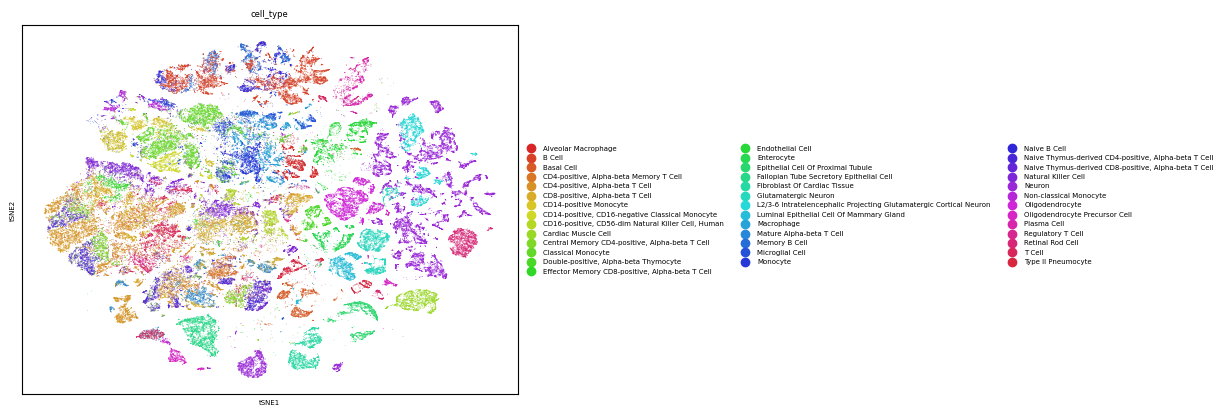

In [126]:
n = 40
cell_freq = adata_zero_shot.obs["cell_type"].value_counts()
adata_plot = adata_zero_shot[adata_zero_shot.obs["cell_type"].isin(cell_freq[:n].index.tolist())].copy()
# Plot t-SNE
sc.pl.tsne(
    adata_plot,
    color="cell_type",
    show=True,
    legend_fontoutline=1,
    palette=generate_colorblind_friendly_colors(n)
)

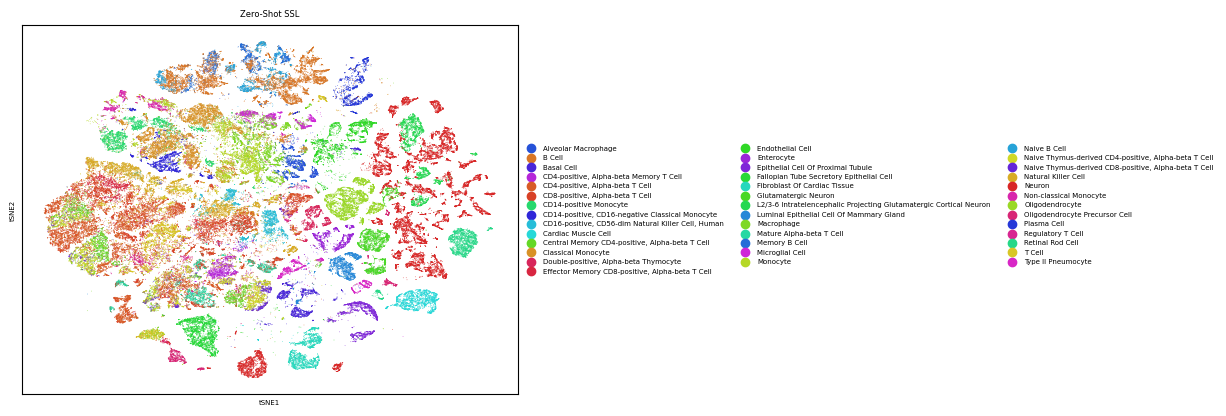

In [150]:
ax = plot_tsne(adata=adata_zero_shot, font_dict=font, cell_freq_thres=3000, save_dir=os.path.join(RESULTS_FOLDER, 'classification'), size=1, title='Zero-Shot SSL')

### Supervised

In [ ]:
embeddings, labels = load_data(embedding_path=os.path.join(RESULTS_FOLDER, 'classification', 'embeddings', 'test_emb_No_SSL_run0_No SSL.npy'), labels=y_true_corrected)
adata = create_subsampled_adata(embeddings, labels, num_samples=200000)

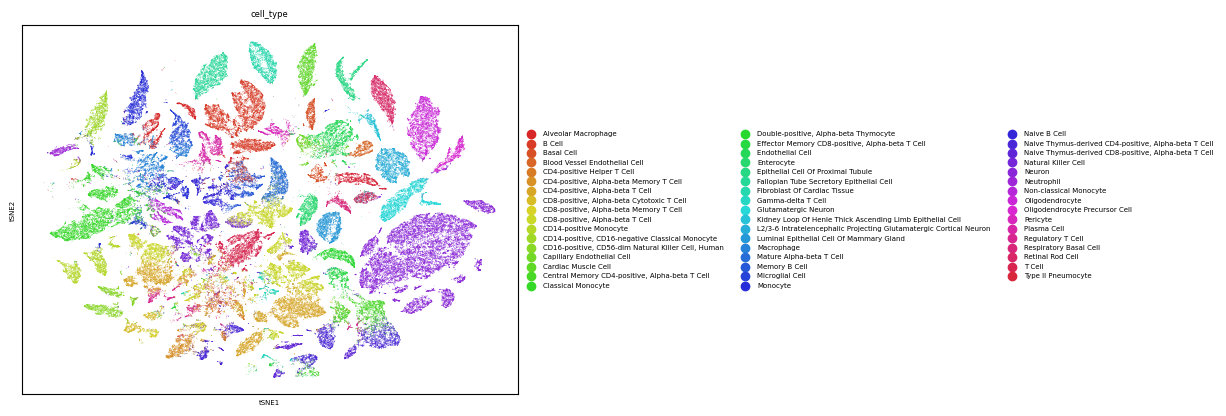

In [118]:
n = 50

adata_plot = adata[adata.obs["cell_type"].isin(cell_freq[:n].index.tolist())].copy()
# Plot t-SNE
sc.pl.tsne(
    adata_plot,
    color="cell_type",
    show=True,
    legend_fontoutline=1,
    palette=generate_colorblind_friendly_colors(n)
)

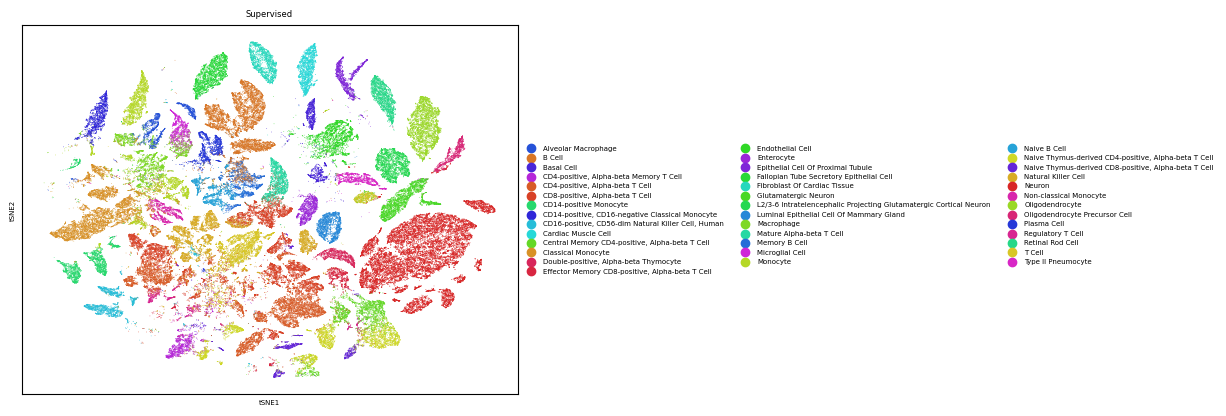

In [151]:
ax = plot_tsne(adata=adata, font_dict=font, cell_freq_thres=3000, save_dir=os.path.join(RESULTS_FOLDER, 'classification'), size=1, title='Supervised')

### PCA

In [100]:
embeddings = np.load(os.path.join(STORE_DIR, 'pca', 'x_pca_test_64.npy'))
adata_pca = create_subsampled_adata(embeddings, y_true, num_samples=200000)

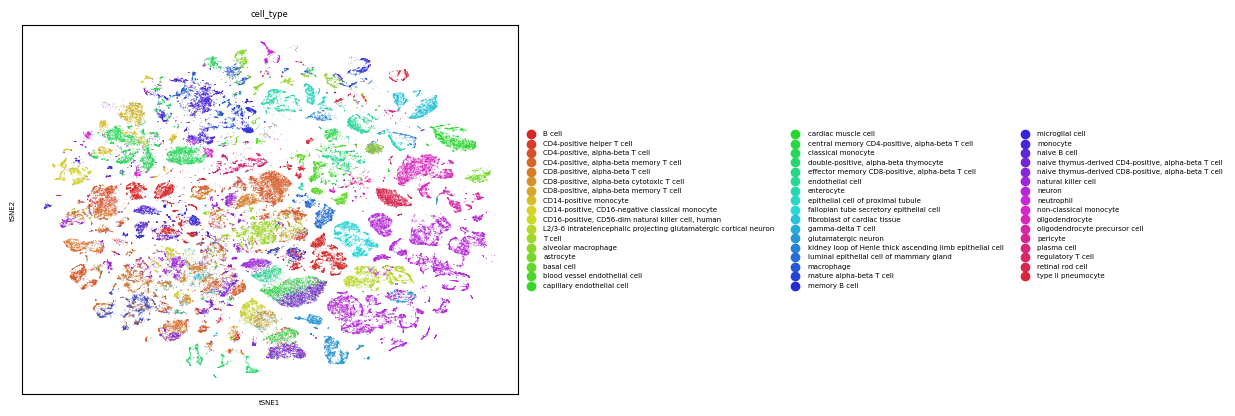

In [119]:
n = 50
cell_freq = adata_pca.obs["cell_type"].value_counts()
adata_plot = adata_pca[adata_pca.obs["cell_type"].isin(cell_freq[:n].index.tolist())].copy()
# Plot t-SNE
sc.pl.tsne(
    adata_plot,
    color="cell_type",
    show=True,
    legend_fontoutline=1,
    palette=generate_colorblind_friendly_colors(n)
)

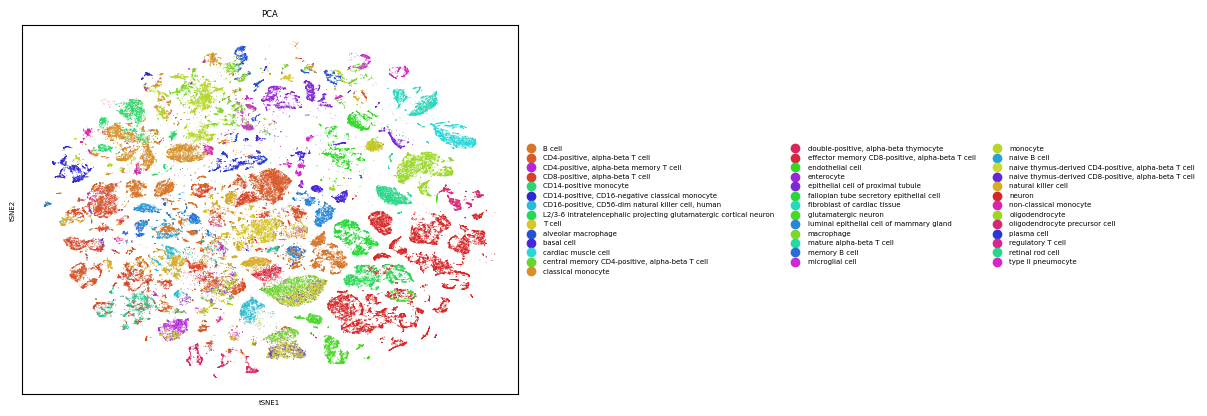

In [152]:
ax = plot_tsne(adata=adata_pca, font_dict=font, cell_freq_thres=3000, save_dir=os.path.join(RESULTS_FOLDER, 'classification'), size=1, title='PCA')